<a href="https://colab.research.google.com/github/Jhatton2/COSC526_M5_SpookyAuthorship/blob/main/M5.12_TeamAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 0: Import Data and

## Unzip Files for CSV Files

In [2]:
import zipfile

# Paths to the zip files
test_zip_path = 'test.zip' # Update this with the correct path if needed
train_zip_path = 'train.zip' # Update this with the correct path if needed

# Unzip test.zip in the current directory
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current working directory

# Unzip train.zip in the current directory
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current working directory

print("Unzipping complete.")


Unzipping complete.


## Create PySpark Session

### Read test.csv

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spooky Author") \
    .getOrCreate()

csv_file_path = './test.csv'
test_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

### Read train.csv

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spooky Author") \
    .getOrCreate()

csv_file_path = './train.csv'
train_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

## Exploring structure, size, and distribution of information

### Training Data

In [5]:
# Find null rows with null values in the training dataset
# Only including columns that are relevant to the analysis.
print("Null rows with null value in the training dataset:")
train_df.filter(train_df.text.isNull() | train_df.author.isNull()).count()

Null rows with null value in the training dataset:


0

In [6]:
# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
train_df.show(5)

First 5 rows of the dataframe:
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows



In [7]:
# Print the schema of the dataframe
print("Dataframe Schema:")
train_df.printSchema()

Dataframe Schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



In [8]:
# Print the number of rows in the dataframe
print("Number of rows in the dataframe: " + str(train_df.count()))

# Print the number of columns in the dataframe
print("Number of columns in the dataframe: " + str(len(train_df.columns)))

Number of rows in the dataframe: 19579
Number of columns in the dataframe: 3


In [9]:
# Print the column names of the dataframe
print("Column names of the dataframe:")
print(train_df.columns)

Column names of the dataframe:
['id', 'text', 'author']


19579
Number of unknown authors: 1532
Percentage of unknown authors: 8%



Number of Edgar Allan Poe (EAP) entries: 7044
Percentage of Edgar Allan Poe (EAP) entries: 36%



Number of HP Lovecraft (HPL) entries: 5451
Percentage of HP Lovecraft (HPL) entries: 28%



Number of Mary Shelley (MWS) entries: 5552
Percentage of Mary Shelley (MWS) entries: 28%


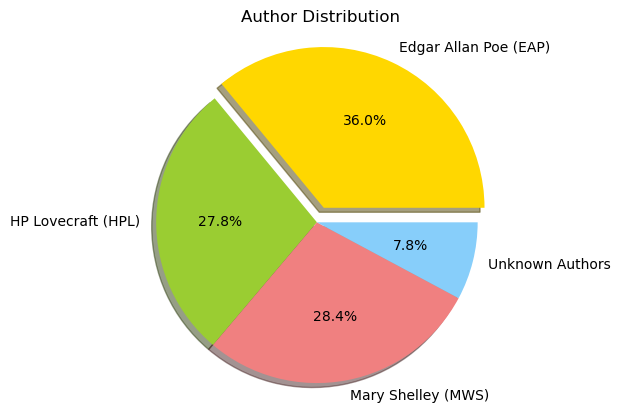

In [10]:
# Show number of each author in the dataframe

eap_author_count = train_df.filter(train_df.author == 'EAP').count()
hpl_author_count = train_df.filter(train_df.author == 'HPL').count()
mws_author_count = train_df.filter(train_df.author == 'MWS').count()

# NOTE: We may want to consider removing the unknown authors from the dataset since
# they do not provide any useful information for training a model. We need an author
# to train the model to predict the author of the text.
unknown_authors = train_df.filter(train_df.author != 'MWS')
unknown_authors = unknown_authors.filter(unknown_authors.author != 'HPL')
unknown_authors = unknown_authors.filter(unknown_authors.author != 'EAP')
unknown_author_count = unknown_authors.count()

total_author_count = train_df.count()

print(total_author_count)

print("Number of unknown authors: " + str(unknown_author_count))
print("Percentage of unknown authors: " + str(round((unknown_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of Edgar Allan Poe (EAP) entries: " + str(eap_author_count))
print("Percentage of Edgar Allan Poe (EAP) entries: " + str(round((eap_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of HP Lovecraft (HPL) entries: " + str(hpl_author_count))
print("Percentage of HP Lovecraft (HPL) entries: " + str(round((hpl_author_count/total_author_count)*100)) + "%")

print("\n\n")

print("Number of Mary Shelley (MWS) entries: " + str(mws_author_count))
print("Percentage of Mary Shelley (MWS) entries: " + str(round((mws_author_count/total_author_count)*100)) + "%")



# Show pie chart of author distribution
import matplotlib.pyplot as plt

# Data to plot
labels = 'Edgar Allan Poe (EAP)', 'HP Lovecraft (HPL)', 'Mary Shelley (MWS)', 'Unknown Authors'
sizes = [eap_author_count, hpl_author_count, mws_author_count, unknown_author_count]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title("Author Distribution")
plt.show()

### Test Data

In [11]:
# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
test_df.show(5)

First 5 rows of the dataframe:
+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



In [12]:
# Print the schema of the dataframe
print("Dataframe Schema:")
test_df.printSchema()

Dataframe Schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)



In [13]:
# Print the number of rows in the dataframe
print("Number of rows in the dataframe: " + str(test_df.count()))

# Print the number of columns in the dataframe
print("Number of columns in the dataframe: " + str(len(test_df.columns)))

Number of rows in the dataframe: 8392
Number of columns in the dataframe: 2


In [14]:
# Print the column names of the dataframe
print("Column names of the dataframe:")
print(test_df.columns)

Column names of the dataframe:
['id', 'text']


# Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing

## Data Cleaning

In [15]:
# Remove the rows with unknown author values from the training dataset
train_df_cleaned = train_df.filter(train_df.author == 'MWS')
train_df_cleaned = train_df_cleaned.union(train_df.filter(train_df.author == 'HPL'))
train_df_cleaned = train_df_cleaned.union(train_df.filter(train_df.author == 'EAP'))

## Data Pre-Processing

In [16]:
# Text tokenization and stop word removal

from pyspark.ml.feature import Tokenizer, StopWordsRemover
new_text_column_name = "tokens"

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol=new_text_column_name)
train_df_cleaned = tokenizer.transform(train_df_cleaned)

# Remove stop words from the text column
remover = StopWordsRemover(inputCol=new_text_column_name, outputCol=new_text_column_name + "_filtered")
train_df_cleaned = remover.transform(train_df_cleaned)

# Show the first 5 rows of the dataframe
print("First 5 rows of the dataframe:")
train_df_cleaned.show(5)

First 5 rows of the dataframe:
+-------+--------------------+------+--------------------+--------------------+
|     id|                text|author|              tokens|     tokens_filtered|
+-------+--------------------+------+--------------------+--------------------+
|id27763|How lovely is spr...|   MWS|[how, lovely, is,...|[lovely, spring, ...|
|id22965|A youth passed in...|   MWS|[a, youth, passed...|[youth, passed, s...|
|id00912|I confess that ne...|   MWS|[i, confess, that...|[confess, neither...|
|id16737|"He shall find th...|   MWS|["he, shall, find...|["he, shall, find...|
|id12799|He had escaped me...|   MWS|[he, had, escaped...|[escaped, me,, mu...|
+-------+--------------------+------+--------------------+--------------------+
only showing top 5 rows



## Data Visualizations

In [17]:
#Get individual words from tokens_filtered column
words_df = train_df_cleaned.selectExpr(f"explode({new_text_column_name}_filtered) as word")

# Count the occurrences of each word
word_counts = words_df.groupBy("word").count().orderBy('count', ascending=False)

# Show counts
word_counts.show(10)

+------+-----+
|  word|count|
+------+-----+
|   one| 1361|
|  upon| 1252|
|  even|  650|
|   yet|  618|
| might|  570|
|  like|  533|
|   old|  529|
|  must|  510|
|seemed|  503|
| first|  503|
+------+-----+
only showing top 10 rows



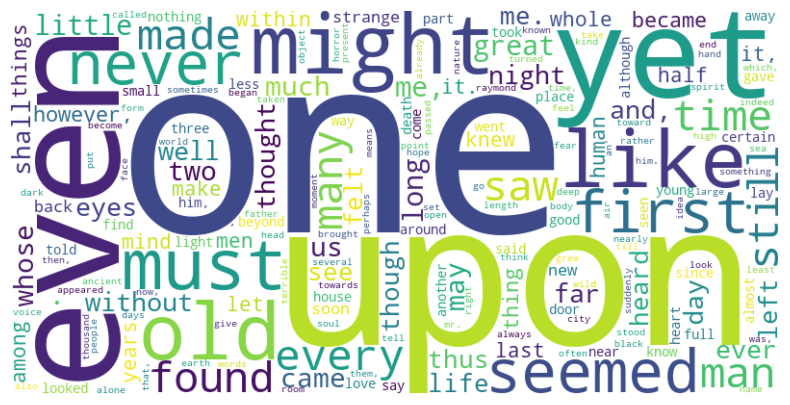

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Converting word_counts to dict
word_counts_pd = word_counts.toPandas()

word_freq_dict = dict(zip(word_counts_pd['word'], word_counts_pd['count']))

#Creating wordcloud
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white', colormap = 'viridis').generate_from_frequencies(word_freq_dict)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Stage 2: Feature Extraction

### TF-IDF

In [19]:
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StringIndexer
from pyspark.ml import Pipeline

# Stage 2.5 TF-IDF

# count the occurrences of each word
vectorizer = CountVectorizer(inputCol=new_text_column_name + "_filtered", outputCol=new_text_column_name+"_vectorized")

# get frequency scores to reflect the importance of words
idf = IDF(inputCol=new_text_column_name+"_vectorized", outputCol="tfidf")

# normalize tfidf scores
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized")

# convert authors to numbers
indexer = StringIndexer(inputCol="author", outputCol="label")

# apply all transformations
pipeline = Pipeline(stages=[vectorizer, idf, normalizer, indexer])

train_df_tfidf = pipeline.fit(train_df_cleaned).transform(train_df_cleaned)
print(f'{train_df_tfidf.printSchema()=}')
train_df_tfidf.select("text", "tokens", "tfidf", "normalized").show(n=5, truncate=False)

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_vectorized: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- normalized: vector (nullable = true)
 |-- label: double (nullable = false)

train_df_tfidf.printSchema()=None
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------

### Normalize

In [20]:
from pyspark.sql import functions

# Stage 2.6 Normalize - convert text to lowercase and special characters
lowered_text = functions.lower(functions.col("text"))
spec_char_removed_text = functions.regexp_replace(lowered_text, "[^a-z0-9\\s]", "")
train_df_normalized = train_df_tfidf.withColumn("spec_char_removed_text", spec_char_removed_text)

# Stage 3: Machine Learning

In [21]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Stage 3.7 - Train Test Split
X_train, X_test = train_df_normalized.randomSplit([0.8, 0.2])

# Stage 3.8 - Supervised Training

# supervised models
models = {
    "logisticReg_model": LogisticRegression(featuresCol="normalized", labelCol="label"),
    "decisionTree_model": DecisionTreeClassifier(featuresCol="normalized", labelCol="label"),
    "randomForest_model": RandomForestClassifier(featuresCol="normalized", labelCol="label"),
    "naive_bayes_model": NaiveBayes(featuresCol="normalized", labelCol="label")
}

# discover which supervised model does best predicting the author
results = {}
for model_name, model in models.items():
    #train
    trained_model = model.fit(X_train)

    # predict
    y_pred = trained_model.transform(X_test)

    # evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(y_pred)
    results[model_name] = { "accuracy": accuracy, "y_pred": y_pred }
    print(f"{model_name}: {accuracy=}")

    # checking predictions
    y_pred.select("label", "prediction").show(5)

highest_accuracy = 0
best_model = None
# iterate over the results dictionary and get the highest accuracy of each model
for model_name, result in results.items():
    if result["accuracy"] > highest_accuracy:
        highest_accuracy = result["accuracy"]
        best_model = model_name

print(f'Best performing supervised model: {best_model}={highest_accuracy}')

logisticReg_model: accuracy=0.7293274531422271
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 5 rows

decisionTree_model: accuracy=0.4255788313120176
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows

randomForest_model: accuracy=0.4181367144432194
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 5 rows

naive_bayes_model: accuracy=0.7885887541345094
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       2.0|
+-----+----------+
only showing top 5 rows

Best performing supervised

### Unsupervised Learning

In [22]:
from pyspark.ml.clustering import KMeans

unlabeled_df = train_df_normalized.drop("author") #actual label of the text
unlabeled_df = unlabeled_df.drop("label") #numerical label created by the StringIndexer
kmeans = KMeans(k=3, maxIter=40, featuresCol="normalized", predictionCol="prediction") # can change the maxIter
kmeans_model = kmeans.fit(unlabeled_df)
predicted_clusters = kmeans_model.transform(train_df_normalized) #labeled data clusters
# lets ignore the Silhouette score since we want to know how well it did at classifcaiton not the clustering

def calculate_accuracy(predictions):
    author_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
    correct_count = 0
    total_rows = predictions.count()

    for row in predictions.collect():
        if author_dict.get(row.author) == row.prediction: # there was a match
            correct_count += 1
    accuracy = correct_count / total_rows
    return accuracy

accuracy = calculate_accuracy(predicted_clusters) #  how well the clusters align with the true labels
print(f'{accuracy=}')

accuracy=0.39025876877043275


# Stage 4: Evaluation and Visualizations

## Evaluation

In [23]:
findings = """
    Logistic Regression, Naives Bayes, Decision Tree, and Random Forest were all evaluated, each with varying levels of accuracy. Along
with these supervised models, we attempted to cluster the data using KMeans to see if the model could predict the author based on the text.
This unsupervised model was not able to accurately predict the author based on the text. Our KMeans model was only able to achieve an accuracy
of 0.30. On the other hand, the supervised models were able to achieve higher accuracy. The Random Forest model was able to achieve
an accuracy of 0.42. The decision tree model was able to achieve an accuracy of 0.43. The logistic regression model was able to achieve
an accuracy of 0.73. The logicstic regression model has a good accuracy, but it was not as high as the naive bayes model which was able
to achieve an accuracy of 0.80. The naive bayes model was the best performing model out of all the models that were tested.

    During our testing of each of these models, we found that this dataset worked best with supervised models. The supervised models were
able to achieve higher accuracy than the unsupervised model. We would not have been able to achieve of our levels of accuracy without
the use of TF-IDF and normalization. These two techniques were able to help standardize the data for effective model training.
As there was only text to use as features in training the models, more advanced feature extraction and feature engineering techniques
could be used to improve model performance. Techniques such as word embedding could be used to capture deeper semantic meaning in the
text.

    The next steps based on our findings would be to better tune the hyperparameters of each models to boost their performance as mentioned above.
We could also try using other supervised and unsupervised machine learning algorithms like Support Vector Machines (SVM). We did not use
many unsupervised models in this analysis, so we could try using more unsupervised models to better compared performances.
"""
print(findings)


    Logistic Regression, Naives Bayes, Decision Tree, and Random Forest were all evaluated, each with varying levels of accuracy. Along
with these supervised models, we attempted to cluster the data using KMeans to see if the model could predict the author based on the text.
This unsupervised model was not able to accurately predict the author based on the text. Our KMeans model was only able to achieve an accuracy
of 0.30. On the other hand, the supervised models were able to achieve higher accuracy. The Random Forest model was able to achieve
an accuracy of 0.42. The decision tree model was able to achieve an accuracy of 0.43. The logistic regression model was able to achieve
an accuracy of 0.73. The logicstic regression model has a good accuracy, but it was not as high as the naive bayes model which was able
to achieve an accuracy of 0.80. The naive bayes model was the best performing model out of all the models that were tested.

    During our testing of each of these models, we 

## Visualizations

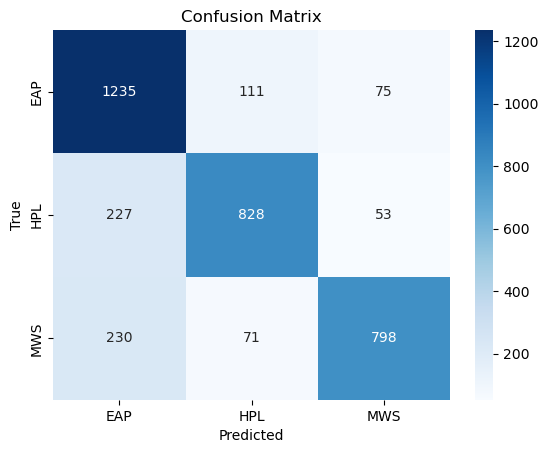

In [24]:
# Display the confusion matrix for the best model
y_pred = results[best_model]["y_pred"]

y_pred.groupBy("label", "prediction").count()

# Get the confusion matrix
confusion_matrix = y_pred.groupBy("label", "prediction").count().toPandas().pivot(index='label', columns='prediction', values='count')

# Show the confusion matrix as a heatmap
import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['EAP', 'HPL', 'MWS'], yticklabels=['EAP', 'HPL', 'MWS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
models = {
    "logisticReg_model": LogisticRegression(featuresCol="normalized", labelCol="label"),
    "decisionTree_model": DecisionTreeClassifier(featuresCol="normalized", labelCol="label"),
    "randomForest_model": RandomForestClassifier(featuresCol="normalized", labelCol="label"),
    "naive_bayes_model": NaiveBayes(featuresCol="normalized", labelCol="label")
}

from pyspark.ml.evaluation import MulticlassClassificationEvaluator


accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


metrics = {}

for model_name, model in models.items():

    trained_model = model.fit(X_train)


    y_pred = trained_model.transform(X_test)


    accuracy = accuracy_evaluator.evaluate(y_pred)
    precision = precision_evaluator.evaluate(y_pred)
    recall = recall_evaluator.evaluate(y_pred)
    f1_score = f1_evaluator.evaluate(y_pred)

    # Store the metrics
    metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

# Display
for model_name, model_metrics in metrics.items():
    print(f"Model: {model_name}")
    for metric, value in model_metrics.items():
        print(f"{metric}: {value:.4f}")
    print("-" * 40)

Model: logisticReg_model
Accuracy: 0.7293
Precision: 0.7305
Recall: 0.7293
F1-Score: 0.7295
----------------------------------------
Model: decisionTree_model
Accuracy: 0.4256
Precision: 0.6229
Recall: 0.4256
F1-Score: 0.2991
----------------------------------------
Model: randomForest_model
Accuracy: 0.4181
Precision: 0.7324
Recall: 0.4181
F1-Score: 0.2771
----------------------------------------
Model: naive_bayes_model
Accuracy: 0.7886
Precision: 0.7973
Recall: 0.7886
F1-Score: 0.7883
----------------------------------------


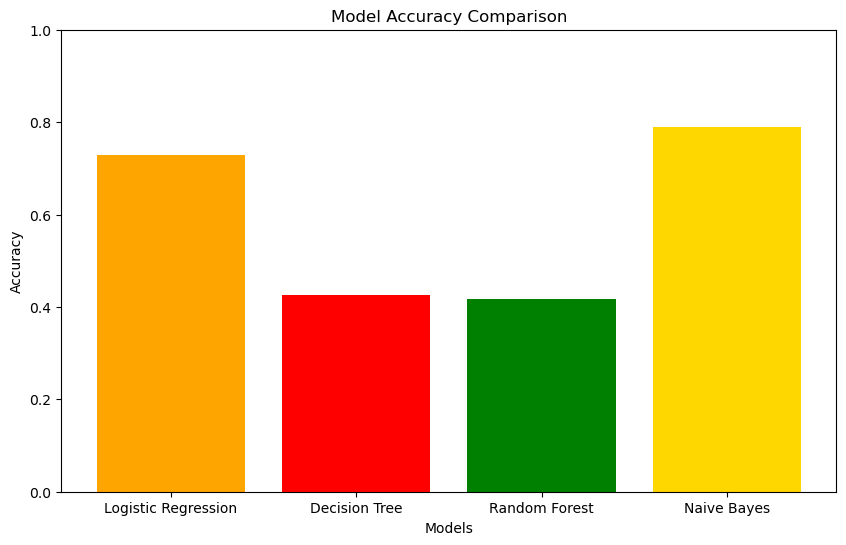

In [28]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes']
accuracies = [0.7293, 0.4256, 0.4181, 0.7886]

colors = ['orange', 'red', 'green', 'gold']  #gold for Naive Bayes

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 1])
plt.show()

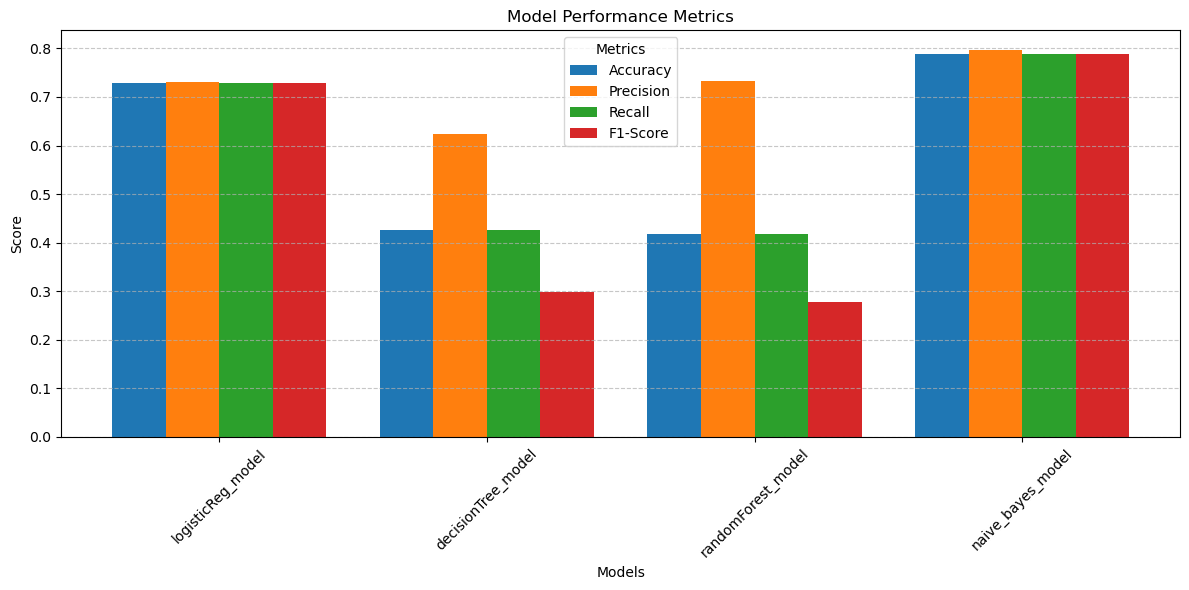

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics calculated for each model
metrics = {
    "logisticReg_model": {"Accuracy": 0.7293, "Precision": 0.7305, "Recall": 0.7293, "F1-Score": 0.7295},
    "decisionTree_model": {"Accuracy": 0.4256, "Precision": 0.6229, "Recall": 0.4256, "F1-Score": 0.2991},
    "randomForest_model": {"Accuracy": 0.4181, "Precision": 0.7324, "Recall": 0.4181, "F1-Score": 0.2771},
    "naive_bayes_model": {"Accuracy": 0.7886, "Precision": 0.7973, "Recall": 0.7886, "F1-Score": 0.7883}
}

# Extract metric names and models
models = list(metrics.keys())
metric_names = list(next(iter(metrics.values())).keys())

# Data preparation for plotting
x = np.arange(len(models))  # X-axis positions for each model
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting each metric as a grouped bar for each model
for i, metric in enumerate(metric_names):
    metric_values = [metrics[model][metric] for model in models]
    ax.bar(x + i * width, metric_values, width, label=metric)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x + width * (len(metric_names) / 2 - 0.5))
ax.set_xticklabels(models, rotation=45)
ax.legend(title="Metrics")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()
